# コンペ概要の理解（ドラフト）

> 公式ページ: https://www.kaggle.com/competitions/hull-tactical-market-prediction

- タスク: 市場に関する将来リターンの予測（詳細な定義・評価指標は公式ページを参照）
- データ構造（手元のtrain/testから推定）:
  - 時系列キー: `date_id`
  - 特徴量群: `D*`, `E*`, `I*`, `M*`, `P*`, `S*`, `V*` などの多数の数値列
  - trainのみ: 目的変数候補 `market_forward_excess_returns` または `forward_returns`、関連指標に `risk_free_rate`
  - test: `is_scored`（採点対象行フラグ）と `lagged_*` 系の説明変数

このノートでは、前処理・特徴量概要・欠損や分布の把握などのEDAを進め、
リーク回避と適切な時系列分割の方針を固めていきます。

## 公式評価コンポーネントの入出力（要点）

- データ供給: `test.csv` を行ID列（既定は `batch_id`、無ければ先頭列）でバッチ分割して `predict` に渡す
- 予測の検証: 返す予測の行数は、受け取った row_ids と一致していなければならない（不一致はエラー）
- 提出生成: 予測と row_ids を結合し、`submission.parquet` を作成（行ID列を先頭に配置、予測列名は既定 `prediction`）
- タイムアウト: 応答は1バッチあたり最大5分。サーバ起動は最大15分で検知
- 評価: Kaggle 側で `is_scored==true` の行に対して RMSE を計算（提出自体は全行が対象）

## 特徴量（公式の説明要約）

> 参考: https://www.kaggle.com/competitions/hull-tactical-market-prediction/data

train.csv（過去の市場データ。カバレッジは数十年に及ぶため、初期期間は欠損が多い点に注意）:

- date_id: 単一の取引日を表す識別子
- M*: Market Dynamics/Technical features（市場ダイナミクス/テクニカル）
- E*: Macro Economic features（マクロ経済）
- I*: Interest Rate features（金利）
- P*: Price/Valuation features（価格/バリュエーション）
- V*: Volatility features（ボラティリティ）
- S*: Sentiment features（センチメント）
- MOM*: Momentum features（モメンタム）
- D*: Dummy/Binary features（二値ダミー）
- forward_returns: S&P 500 を買って翌日売った場合のリターン（train のみ）
- risk_free_rate: フェデラル・ファンド・レート（train のみ）
- market_forward_excess_returns: 期待に対する将来リターンの超過分（5年ローリング平均を差し引き、MAD=4基準でウィンザー化；train のみ）

test.csv（本番と同構造のモック。公開LBは train の最後の180日をコピーしたもので意味が限定的。評価APIが配布する非公開テストは学習期間中に更新され得る）:

- date_id
- [feature_name]: train.csv と同一の特徴列
- is_scored: 評価指標の計算に含めるか（学習フェーズでは先頭180行のみ true；test のみ）
- lagged_forward_returns: forward_returns の1日ラグ
- lagged_risk_free_rate: risk_free_rate の1日ラグ
- lagged_market_forward_excess_returns: market_forward_excess_returns の1日ラグ（同様の処理で算出）

# EDA 概要とデータ方針

このノートでは Hull Tactical Market Prediction のEDAを行います。

- データはGitに含めません。Kaggle APIで毎回取得します。
- 取得手順は `README.md` の「データ運用ポリシー（EDA）」を参照してください。
- 取得スクリプト: `scripts/fetch_data.sh`（事前に `chmod +x` で実行権限を付与）

データ配置（ローカル専用）:
- `data/raw/`: 公式zipの展開先
- `data/interim/`, `data/processed/`, `data/external/`: 必要に応じて中間生成物を配置（Git管理しない）
- `artifacts/`: 学習成果物（Git管理しない）


In [49]:
# Setup: パス定義と表示設定（共通）
from pathlib import Path

import pandas as pd

# ノートブックの親ディレクトリをリポジトリルートとみなす
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
TRAIN_PATH = DATA_RAW / 'train.csv'
TEST_PATH  = DATA_RAW / 'test.csv'

# 表示設定（全カラム可視）
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print('[paths]', TRAIN_PATH, TEST_PATH)

[paths] /workspaces/Hull-Tactical---Market-Prediction/data/raw/train.csv /workspaces/Hull-Tactical---Market-Prediction/data/raw/test.csv


In [50]:
# データの読み込み例
import pandas as pd
from pandas import option_context

# 共通の TRAIN_PATH/TEST_PATH を利用
train_path = str(TRAIN_PATH)
test_path = str(TEST_PATH)

try:
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    # 全カラム名を省略せずに表示
    print('[train] columns (all):')
    print(list(train.columns))
    print('\n[test] columns (all):')
    print(list(test.columns))
    # DataFrame 本体も省略なしで表示（headではなく全列可視を優先）
    with option_context('display.max_columns', None, 'display.width', None):
        print('\n[train] head():')
        display(train.head())
        print('\n[test] head():')
        display(test.head())
except FileNotFoundError as e:
    print("[info] ローカルにデータが見つかりません。先に以下を実行してください:")
    print("  ./scripts/fetch_data.sh")
    raise e

[train] columns (all):
['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

[test] columns (all):
['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12',

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301



[test] head():


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,is_scored,lagged_forward_returns,lagged_risk_free_rate,lagged_market_forward_excess_returns
0,8980,0,0,0,0,1,0,0,1,0,1.577651,0.186177,0.001323,0.001323,0.001323,0.001323,0.955026,-0.583419,-0.704264,0.298365,-0.691361,1.259065,1.556516,1.712580,0.033069,0.333333,0.036376,-0.046483,-0.312326,0.913029,0.306217,1.025756,0.081349,0.478175,0.675627,0.699735,0.256283,0.360450,0.676061,-1.310438,-0.392342,-0.236100,0.169554,-1.196419,-0.760030,0.641204,0.916667,0.289683,0.318783,-0.321981,3.394801,0.110939,0.755237,-0.318948,-0.596875,0.867394,0.348006,0.470569,2.113675,2.247820,0.882724,0.794643,-1.427834,0.352513,0.926257,0.431383,-0.476976,0.500245,1.784173,0.029762,0.294719,0.514550,0.446429,0.466551,0.085717,-0.230132,0.272487,-0.106894,0.199735,0.409392,0.532717,0.744048,0.440476,-0.654839,0.699735,0.699074,-0.502400,0.882937,0.892196,0.828042,0.999172,0.759921,-0.803127,0.170966,-0.751909,True,0.003541,0.000161,0.003068
1,8981,0,0,0,0,1,0,0,1,0,1.575182,0.185847,0.000992,0.000992,0.000992,0.000992,0.955357,-0.583074,-0.703759,0.297608,-0.504499,1.193468,1.554184,1.640054,0.032738,0.333003,0.036045,0.073582,-0.312345,0.913360,0.305886,0.989571,0.082672,0.477844,0.661527,0.719577,0.255952,0.361111,0.660556,-1.234687,-0.357220,-0.220754,0.191398,-1.203526,-0.759527,0.641865,0.852513,0.289021,0.318452,0.380119,0.298001,0.010021,1.126653,-0.314881,-0.597245,0.961640,0.313527,0.331019,2.089552,2.199278,-0.428140,0.711310,-1.376520,0.953042,0.386905,0.523549,-0.421365,-0.234829,1.770175,0.033730,0.304496,0.638228,0.636905,1.849101,0.281690,-0.041995,0.448413,0.094321,0.215608,0.409392,0.597864,0.872354,0.691138,-0.583443,0.629960,0.598545,-0.394268,0.863757,0.699074,0.831349,1.120336,0.556217,-0.686192,0.141865,-0.660326,True,-0.005964,0.000162,-0.006437
2,8982,0,0,0,0,1,0,0,0,1,1.572720,0.185516,0.000661,0.000661,0.000661,0.000661,0.955688,-0.083356,-0.573546,0.225822,-0.393903,1.123361,1.551723,1.562722,0.032407,0.332672,0.035714,0.033581,-0.312364,0.913690,0.291997,1.040514,0.081349,0.477513,0.655741,0.724206,0.226190,0.355820,0.650325,-1.128989,-0.347297,-0.241044,0.199469,-1.189592,-0.757391,0.652116,0.879630,0.288360,0.318122,1.351334,0.391480,-0.233158,0.860735,-0.244248,-0.596983,0.513228,0.276338,0.348545,2.067406,2.149585,0.368688,0.212632,-1.347620,0.210979,0.635251,-1.138198,-0.494248,-1.042718,1.754171,0.032407,0.257609,0.082011,0.152116,-0.201611,0.346373,0.054032,0.137566,0.294305,0.194444,0.409392,0.596528,0.778439,0.634921,-0.483236,0.669974,0.603836,-0.170420,0.848545,0.647487,0.832672,1.088992,0.665344,-0.459367,0.199405,-0.510979,True,-0.007410,0.000160,-0.007882
3,8983,0,0,0,0,1,0,0,0,1,1.570266,0.185185,0.019841,0.019841,0.006614,0.006614,0.956019,-0.083403,-0.573180,0.225094,-0.541646,1.167982,1.549272,1.611215,0.032077,0.332341,0.035384,0.033998,-0.312383,0.914021,0.267196,1.091376,0.085979,0.477183,0.648582,0.728175,0.230159,0.351852,0.649528,-1.150431,-0.300917,-0.145171,0.269389,-1.165139,-0.754948,0.652116,0.853836,0.279431,0.317791,-0.212995,3.032725,0.024158,1.426994,-0.286942,-0.572019,0.681548,0.302134,0.309193,2.079415,2.175705,0.368943,0.660714,-1.399411,0.724868,0.216270,-0.230557,-0.318347,0.396917,1.769678,0.033730,0.202350,0.324074,0.212963,0.052878,-0.049023,0.120828,0.219577,0.137942,0.167328,0.409392,0.579726,0.449735,0.665344,-0.546298,0.590608,0.558862,-0.275099,0.826058,0.445767,0.835979,1.040988,0.594577,-0.561643,0.161706,-0.575997,True,0.005420,0.000160,0.004949
4,8984,0,0,0,0,0,0,1,0,1,1.567818,0.184854,0.019511,0.019511,0.006283,0.006283,0.956349,-0.083449,-0.572813,0.224366,-0.714549,1.243713,1.542543,1.693604,0.031746,0.332011,0.035053,0.029586,-0.301855,0.914352,0.2

In [51]:
# 特徴量グループの件数（ヘッダから集計）
import csv
from collections import Counter
from pathlib import Path


def count_feature_groups(header):
    special = {'date_id','forward_returns','risk_free_rate','market_forward_excess_returns','is_scored'}
    counts = Counter()
    for c in header:
        if not c or c in special or c.startswith('lagged_'):
            continue
        prefix = c[0] if c else None
        if prefix and prefix.isalpha():
            counts[prefix] += 1
    return counts

# train
with TRAIN_PATH.open('r', newline='') as f:
    header_train = next(csv.reader(f))
counts_train = count_feature_groups(header_train)
print('train groups:', dict(sorted(counts_train.items())))

# test
with TEST_PATH.open('r', newline='') as f:
    header_test = next(csv.reader(f))
counts_test = count_feature_groups(header_test)
print('test groups:', dict(sorted(counts_test.items())))
print('test lagged count:', sum(1 for c in header_test if c.startswith('lagged_')))

train groups: {'D': 9, 'E': 20, 'I': 9, 'M': 18, 'P': 13, 'S': 12, 'V': 13}
test groups: {'D': 9, 'E': 20, 'I': 9, 'M': 18, 'P': 13, 'S': 12, 'V': 13}
test lagged count: 3


### タイムキー date_id の整合性チェック（重複・ギャップ）

問題なし

In [52]:
# タイムキー date_id の整合性チェック（重複・ギャップ）
import pandas as pd

# 既存の train/test を再利用、無ければ読み込み
if 'train' not in globals():
    train = pd.read_csv(TRAIN_PATH)
if 'test' not in globals():
    test = pd.read_csv(TEST_PATH)


def check_date_id(df: pd.DataFrame, name: str):
    print(f"\n=== date_id integrity: {name} ===")
    if 'date_id' not in df.columns:
        print('date_id column not found')
        return
    s = df['date_id'].dropna().astype(int)
    n = len(s)
    n_unique = s.nunique()
    dups = n - n_unique
    print({'n': n, 'n_unique': n_unique, 'duplicates': dups})
    if dups > 0:
        vc = s.value_counts()
        dup_vals = vc[vc > 1].index.tolist()[:10]
        print('duplicate date_id examples:', dup_vals)
    # 連続性チェック（min..max 間のギャップ）
    mn, mx = int(s.min()), int(s.max())
    full = set(range(mn, mx + 1))
    missing = sorted(list(full - set(s.tolist())))
    print({'min': mn, 'max': mx, 'range_len': mx - mn + 1, 'missing_count': len(missing)})
    if len(missing) > 0:
        print('missing example:', missing[:20])
    # 近傍差分チェック
    diffs = s.sort_values().diff().dropna()
    gap_counts = diffs.value_counts().head(5)
    print('top diff steps:', gap_counts.to_dict())
    # 判定
    if dups == 0 and len(missing) == 0 and 1 in gap_counts.index and len(gap_counts) == 1:
        print('RESULT: OK (unique and contiguous by step=1)')
    else:
        print('RESULT: ISSUES (see details above)')

check_date_id(train, 'train')
check_date_id(test, 'test')


=== date_id integrity: train ===
{'n': 8990, 'n_unique': 8990, 'duplicates': 0}
{'min': 0, 'max': 8989, 'range_len': 8990, 'missing_count': 0}
top diff steps: {1.0: 8989}
RESULT: OK (unique and contiguous by step=1)

=== date_id integrity: test ===
{'n': 10, 'n_unique': 10, 'duplicates': 0}
{'min': 8980, 'max': 8989, 'range_len': 10, 'missing_count': 0}
top diff steps: {1.0: 9}
RESULT: OK (unique and contiguous by step=1)


## 目的変数・MAD・ウィンザー化（要点）

- 目的変数: `market_forward_excess_returns`（翌日超過リターンから5年ローリング平均を差し引き、MAD=4でウィンザー化済み）
- 超過リターン: r_excess = forward_returns − risk_free_rate
- デトレンド: 5年ローリング平均（過去のみ）を引いて上振れ/下振れに変換
- ウィンザー化（MAD=4）: 中央値 m と MAD を用い、[m−4×MAD, m+4×MAD] にクリップ（外れ値を境界に置換）
- 評価: test の is_scored==true 行に対する RMSE
- リーク防止: ローリング統計は shift(1) で「その時点直前まで」のデータに限定して算出する

In [53]:
# MAD=4 のウィンザー化デモ（リーク防止の rolling+shift 例）
from pathlib import Path

import numpy as np
import pandas as pd

# 共通の TRAIN_PATH を利用
train_csv = TRAIN_PATH

def compute_mad_winsorized(series: pd.Series, k: float = 4.0) -> pd.Series:
    """
    series: 時系列データ（時刻順に並んでいる前提）
    k: MAD 係数（k=4なら MAD=4）
    処理: 中央値m_t と MAD_t を、各時点tで『t-1まで』のデータから求め、[m_t-k*MAD_t, m_t+k*MAD_t] にクリップ
    """
    s = series.astype(float).copy()
    # 過去のみで中央値とMADを計算
    med = s.shift(1).expanding().median()
    abs_dev = (s.shift(1) - med).abs()
    mad = abs_dev.expanding().median()
    lower = med - k * mad
    upper = med + k * mad
    return s.clip(lower=lower, upper=upper)

if train_csv.exists():
    df = pd.read_csv(train_csv, usecols=['date_id','forward_returns','risk_free_rate','market_forward_excess_returns'])
    df = df.sort_values('date_id').reset_index(drop=True)
    r_excess = df['forward_returns'] - df['risk_free_rate']
    # ここでは 5年ローリング平均の再現は行わず（提供済みラベルを使用する想定）、
    # MAD=4のウィンザー化処理のデモのみを示す。
    y = df['market_forward_excess_returns']
    y_wins = compute_mad_winsorized(y, k=4.0)
    print('データあり: y と winsorized(y) の基本統計')
    print(pd.DataFrame({'y': y.describe(), 'y_wins': y_wins.describe()}))
else:
    # 合成データ: 正規 + 外れ値
    rng = np.random.default_rng(0)
    base = rng.normal(loc=0.0, scale=1.0, size=500)
    base[::50] += 8  # 外れ値を混ぜる
    s = pd.Series(base)
    s_wins = compute_mad_winsorized(s, k=4.0)
    print('合成データ: before/after の標準偏差比較')
    print({'std_before': float(s.std()), 'std_after': float(s_wins.std())})

データあり: y と winsorized(y) の基本統計
                 y       y_wins
count  8990.000000  8990.000000
mean      0.000051     0.000123
std       0.010568     0.009139
min      -0.040582    -0.023466
25%      -0.004759    -0.004752
50%       0.000252     0.000248
75%       0.005479     0.005479
max       0.040551     0.024789


## 欠損サマリ

所見:
- 初期期間ほど欠損率が高く、`date_id` の進行に伴い改善する列が多い。
- 同一プレフィックス群（例: E*, M*, V* など）で欠損率が似通う傾向があり、共通の参照元/計算起点を示唆。
- 連続値の特徴は欠損があっても中央値/過去推定での補完が機能しやすい一方、二値系（D*）の欠損は意味を持つ可能性があるため別扱いが望ましい。
- 欠損が恒常的に高い列は情報価値が低い可能性があり、削除や高次集約での代替を検討。

ToDo:
- 欠損処理方針の分岐を設計:
  - 連続値: 時系列文脈での前方補間/ロールング中央値（shift(1)）/単純中央値の比較。
  - 二値: 欠損フラグ追加 + モード/0埋めの比較。
- `date_id` 初期のウォームアップ期間（欠損多発）を学習から除外する閾値を検討。
- 欠損率しきい値（例: >80%）での列除去と、相関/重要度に基づく再評価。
- 推論時ガード: 推論データの欠損発生を想定し、学習時と同一ロジックでの安全な補完を関数化。

In [54]:
# 欠損率・型情報のサマリ関数と出力（全件も可、表の省略なし）
import numpy as np
import pandas as pd
from pandas import option_context


def missing_summary(df: pd.DataFrame, top_n: int | None = 30) -> pd.DataFrame:
    na_cnt = df.isna().sum()
    na_pct = na_cnt / len(df) * 100.0
    out = (
        pd.DataFrame({'missing_count': na_cnt, 'missing_pct': na_pct, 'dtype': df.dtypes.astype(str)})
        .sort_values('missing_pct', ascending=False)
    )
    if top_n is not None:
        out = out.head(top_n)
    return out

print('\n--- Missing summary (train): ALL ---')
train_missing_all = missing_summary(train, None)
with option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None, 'display.max_colwidth', None):
    display(train_missing_all)

print('\n--- Dtype counts (test) ---')
print(test.dtypes.value_counts())
print('\n--- Missing summary (test): top 20 ---')
with option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None, 'display.max_colwidth', None):
    display(missing_summary(test, 20))


--- Missing summary (train): ALL ---


,missing_count,missing_pct,dtype
E7,6969,77.519466,float64
V10,6049,67.285873,float64
S3,5733,63.770857,float64
M1,5547,61.701891,float64
M13,5540,61.624027,float64
M14,5540,61.624027,float64
M6,5043,56.095662,float64
V9,4539,50.489433,float64
S12,3537,39.343715,float64
M5,3283,36.518354,float64



--- Dtype counts (test) ---
float64    88
int64      10
bool        1
Name: count, dtype: int64

--- Missing summary (test): top 20 ---


,missing_count,missing_pct,dtype
date_id,0,0.0,int64
D1,0,0.0,int64
D2,0,0.0,int64
D3,0,0.0,int64
D4,0,0.0,int64
D5,0,0.0,int64
D6,0,0.0,int64
D7,0,0.0,int64
D8,0,0.0,int64
D9,0,0.0,int64


## 特徴量の分布

所見:
- 多くの連続特徴量はゼロ付近に集中し裾が厚い（ファットテール）。外れ値の影響を受けやすい。
- 群ごと（M*, E*, V* など）にスケール・分散の大小が異なるため、正規化/標準化の必要性が高い。
- 一部は非対称（歪度が大きい）で、ロバストスケーリング（QuantileTransformer/RobustScaler）や対数変換が有効な可能性。
- 二値/ダミーは極端な不均衡（0/1 偏り）がある列が存在し、情報量が限定的な可能性。

ToDo:
- スケーリング方針の比較: StandardScaler vs RobustScaler vs Rank/Quantile。
- 外れ値対策: クリッピング/ウィンザー化/ロバスト損失の適用でモデル安定性を比較。
- 低分散/定数列の除去、自動検出のユーティリティ化。
- 分布の安定性検証: train 後半 vs test で分布シフトがないかKS検定などで点検。

Target describe:
count    8990.000000
mean        0.000051
std         0.010568
min        -0.040582
1%         -0.032072
5%         -0.018087
50%         0.000252
95%         0.016440
99%         0.031148
max         0.040551
Name: market_forward_excess_returns, dtype: float64
{'skew': -0.17794833780444028, 'kurtosis': 2.238481077014922}


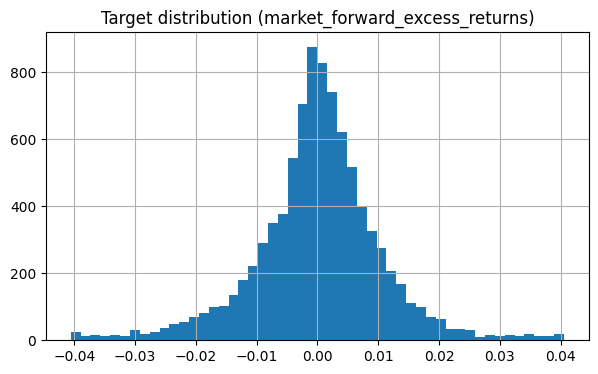

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9
count,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,7206.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7374.000000,7984.000000,7984.000000,7984.000000,7984.000000,2021.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,3443.000000,7984.000000,7984.000000,7984.000000,3450.000000,3450.000000,7984.000000,7984.000000,7984.000000,7984.000000,5773.000000,6972.000000,7984.000000,5707.000000,3947.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,7416.000000,7352.000000,7374.000000,7984.000000,7984.000000,7984.000000,7984.000000,7984.000000,5453.000000,7984.000000,3257.000000,7984.000000,7479.000000,7984.000000,7984.000000,5981.000000,7984.000000,7984.000000,2941.000000,7984.000000,7984.000000,7479.000000,7984.000000,7984.000000,7984.000000,7478.000000,7984.000000,7479.000000,7984.000000,4451.000000
mean,0.031591,0.031591,0.047831,0.575195,0.190656,-0.238042,0.045717,0.142825,0.143159,1.564574,0.504941,0.125869,0.118739,0.012314,0.007005,0.485070,-0.047127,-0.007330,0.097865,0.118793,0.500651,0.902917,0.340552,0.016795,0.599603,0.122388,-0.036545,-0.272055,0.263144,0.746876,-0.528014,0.609559,0.551387,0.184905,0.455500,0.708263,0.573509,0.186401,-0.615668,0.060733,-0.289190,0.479752,-0.949367,-0.864795,0.461721,0.230523,0.272516,0.600668,0.085922,0.144819,-0.002462,0.229007,0.232493,0.003242,0.435199,0.381656,0.528253,1.466365,1.256251,-0.024978,0.508856,-0.360545,0.495245,0.500661,0.000385,0.053780,0.249488,1.542002,0.395020,0.240486,0.437665,0.432784,0.264418,0.024570,0.059115,0.456098,0.035091,0.515581,0.493256,0.075114,0.456686,0.325620,0.001032,0.230107,0.253250,0.112494,0.508928,0.489553,0.506930,0.372494,0.287179,0.148270,0.303908,0.129227
std,0.174917,0.174917,0.213420,0.494341,0.392840,0.425909,0.208883,0.349914,0.350254,0.633895,0.336922,0.245719,0.251961,0.019263,0.012097,0.348769,1.137741,1.159378,1.146872,1.247622,1.424679,1.272464,1.506653,0.041870,0.337506,0.222050,1.925521,1.514817,0.298619,0.244606,1.251869,0.331043,0.307272,1.642350,0.302659,0.256784,0.326068,1.641860,0.999743,1.317935,1.223822,1.397498,0.653691,0.192728,0.273502,0.326291,0.226982,0.343911,1.092240,1.220674,1.094271,1.550665,1.364828,1.020493,0.317701,1.411880,0.327812,0.814272,1.095607,1.082758,0.283946,1.445499,0.288396,0.288187,1.070578,1.152703,1.133184,0.708787,0.385524,1.422965,0.322464,0.324821,0.956038,1.024633,1.010071,0.326589,1.136382,0.289200,0.306598,1.098363,0.328205,0.346319,1.246824,0.316092,0.306635,1.331013,0.306477,0.306230,0.306554,1.153280,0.312238,1.326879,0.351109,1.277273
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.325149,0.000661,0.000661,0.000661,0.000661,0.000661,0.000661,-5.130519,-4.302885,-4.131097,-1.826114,-4.675791,-3.308764,-5.374951,0.000661,0.000661,0.000661,-19.918972,-2.457316,0.000661,0.002646,-3.542308,0.000661,0.000661,-4.449235,0.000661,0.003307,0.000661,-4.546619,-2.522870,-4.765828,-3.190249,-2.993367,-1.932110,-1.325950,0.000661,0.000661,0.000661,0.000661,-2.667421,-1.802507,-9.389925,-3.424095,-2.469748,-4.317569,0.000661,-2.831429,0.000661,-1.162766,-2.719004,-1.539300,0.002315,-3.140889,0.043981,0.066138,-1.430121,-0.780115,-3.138174,-1.782276,0.000661,-1.935367,0.000661,0.000661,-2.103472,-3.429761,-3.472202,0.000661,-13.124619,0.000661,0.000661,-3.876846,0.000661,0.000661,-1.473543,0.000661,0.000661,-4.770347,0.000661,0.00066

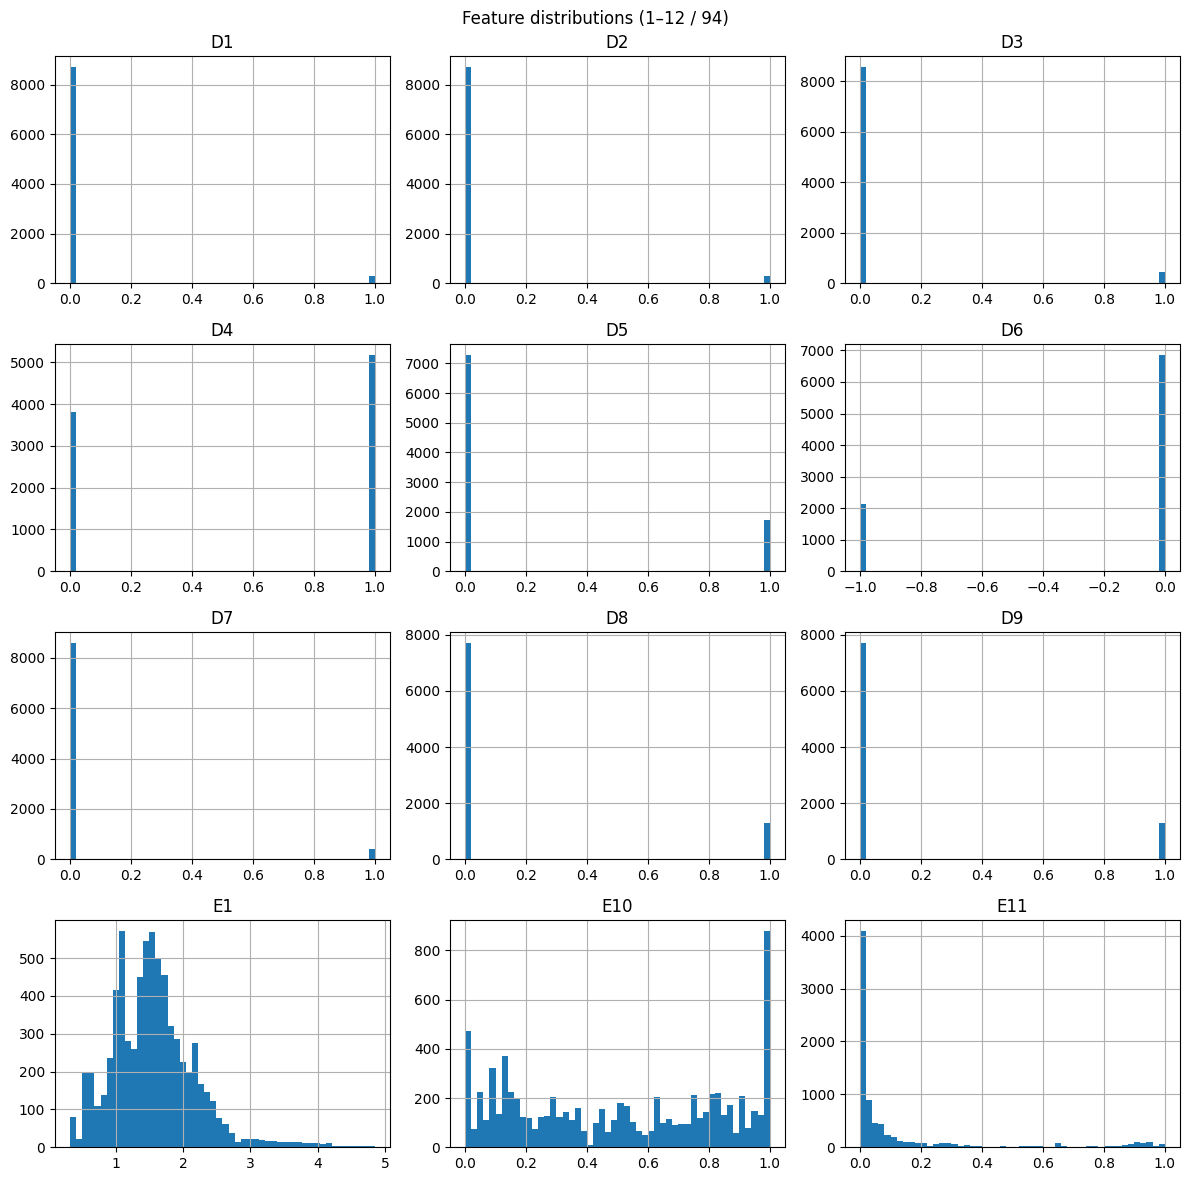

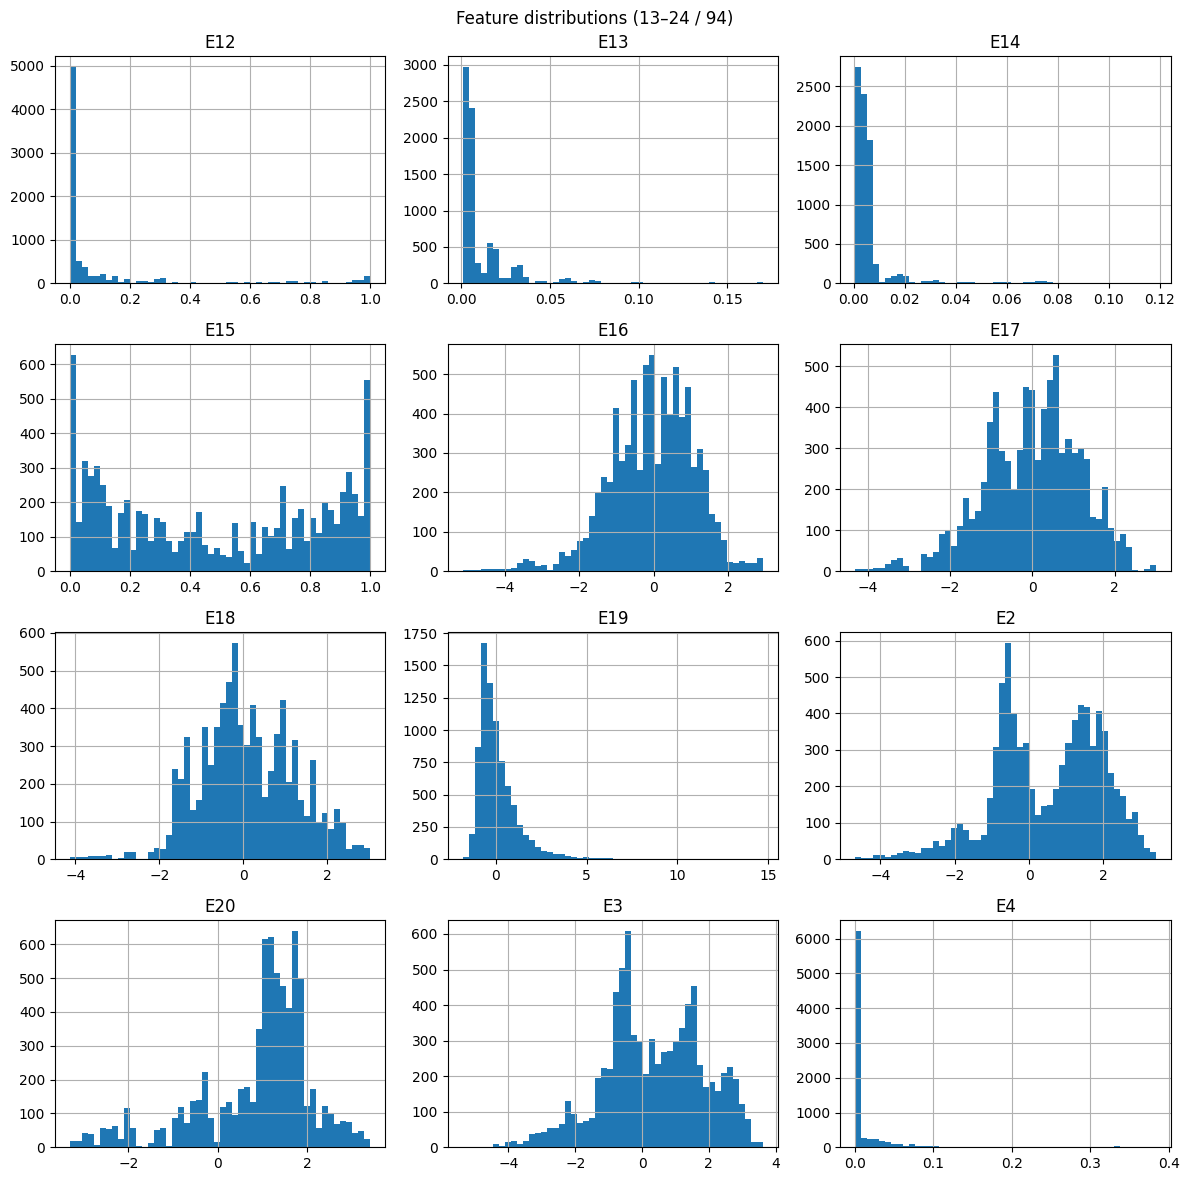

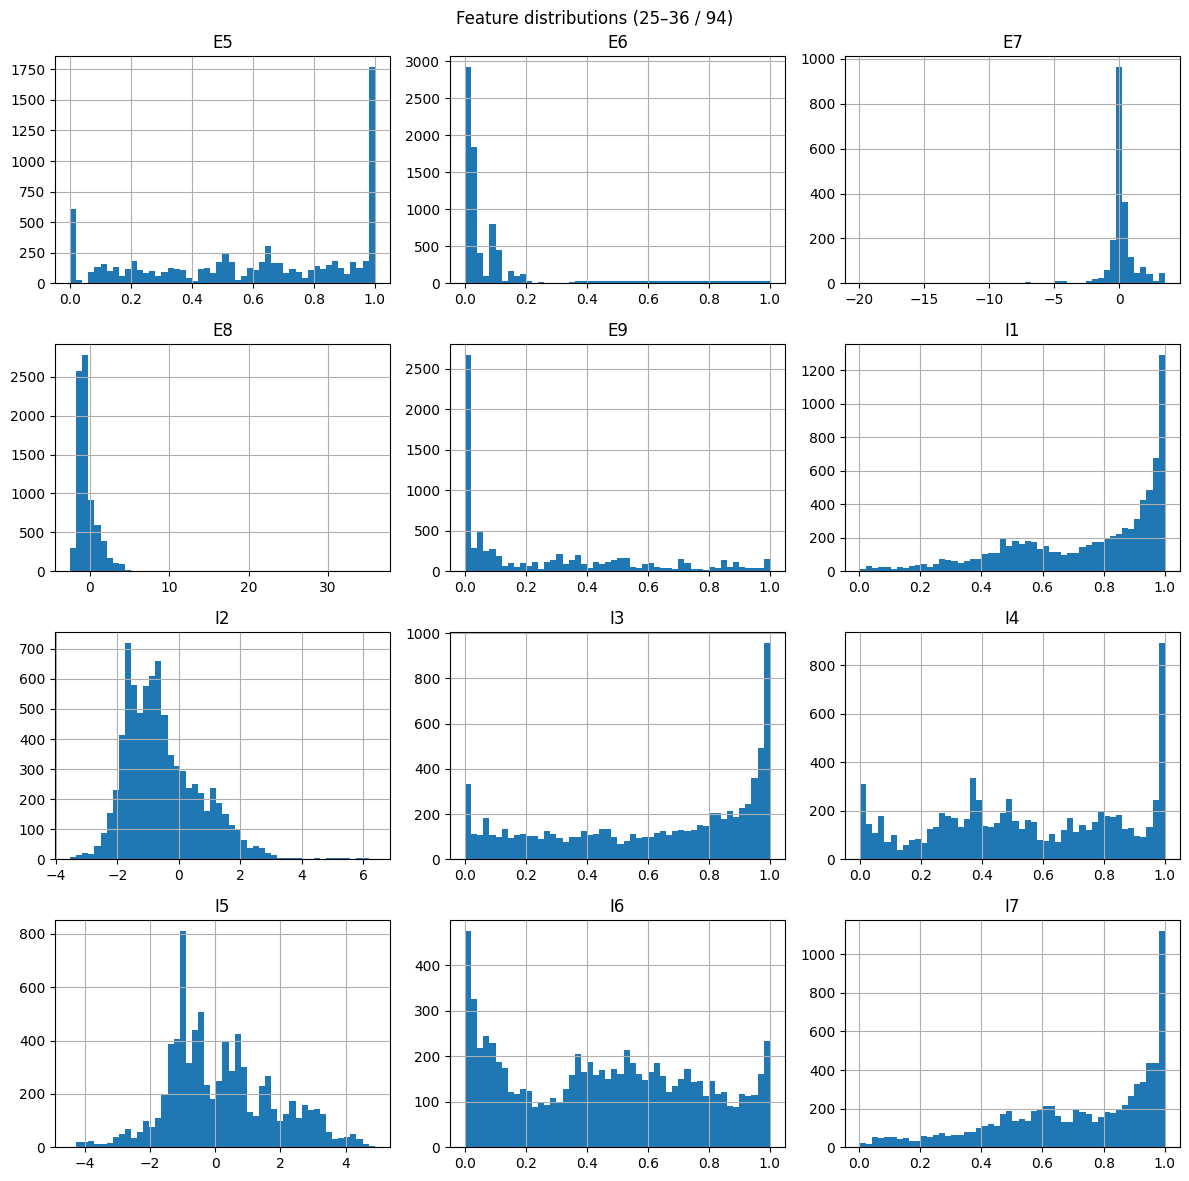

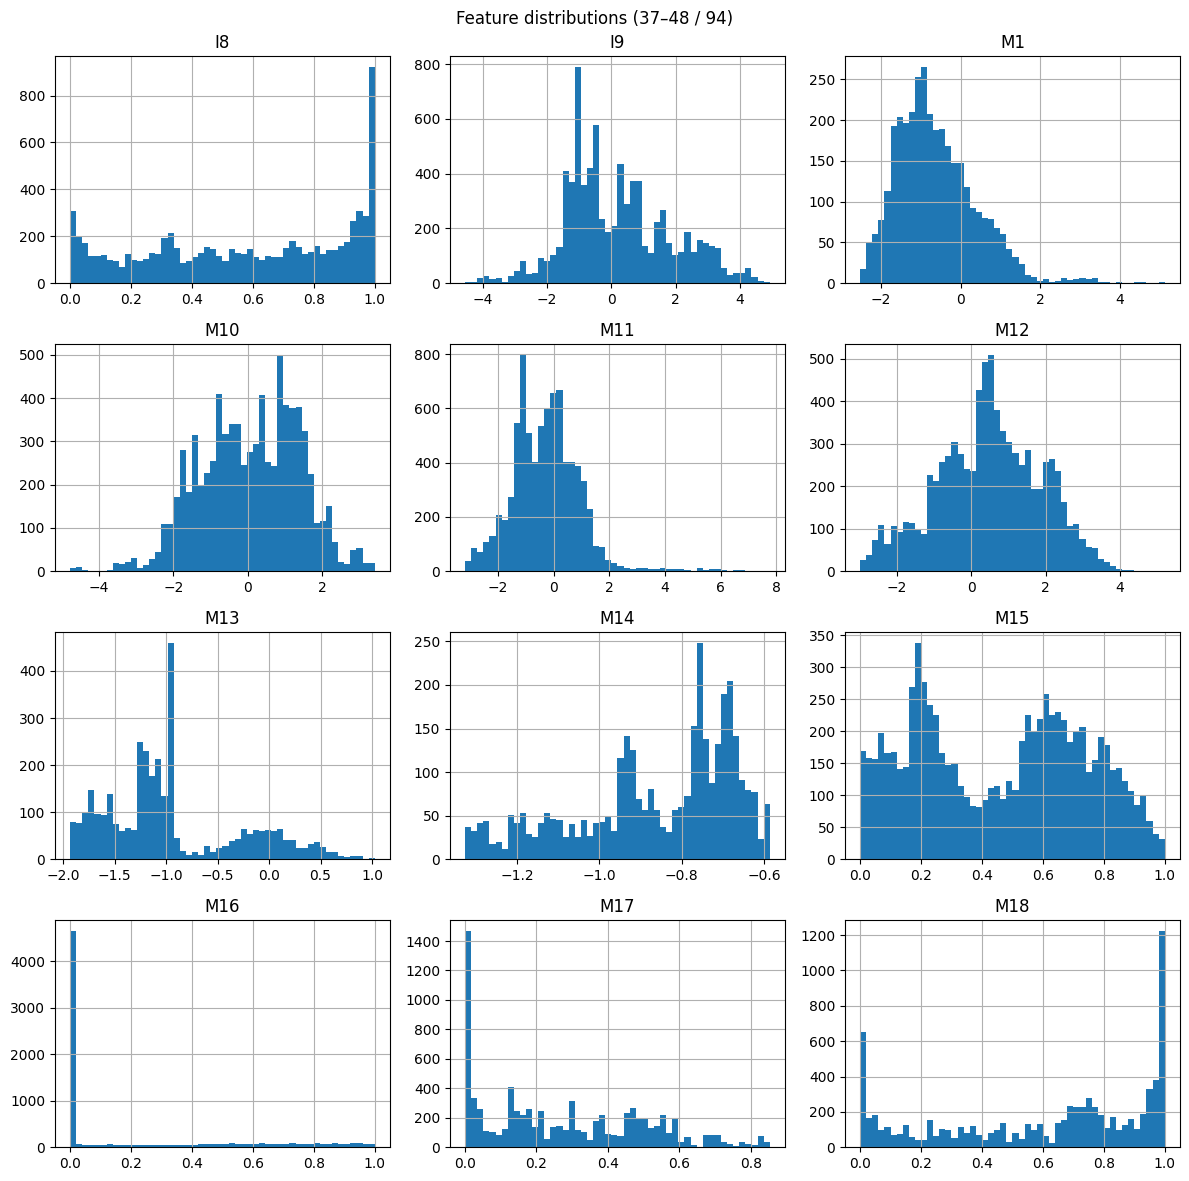

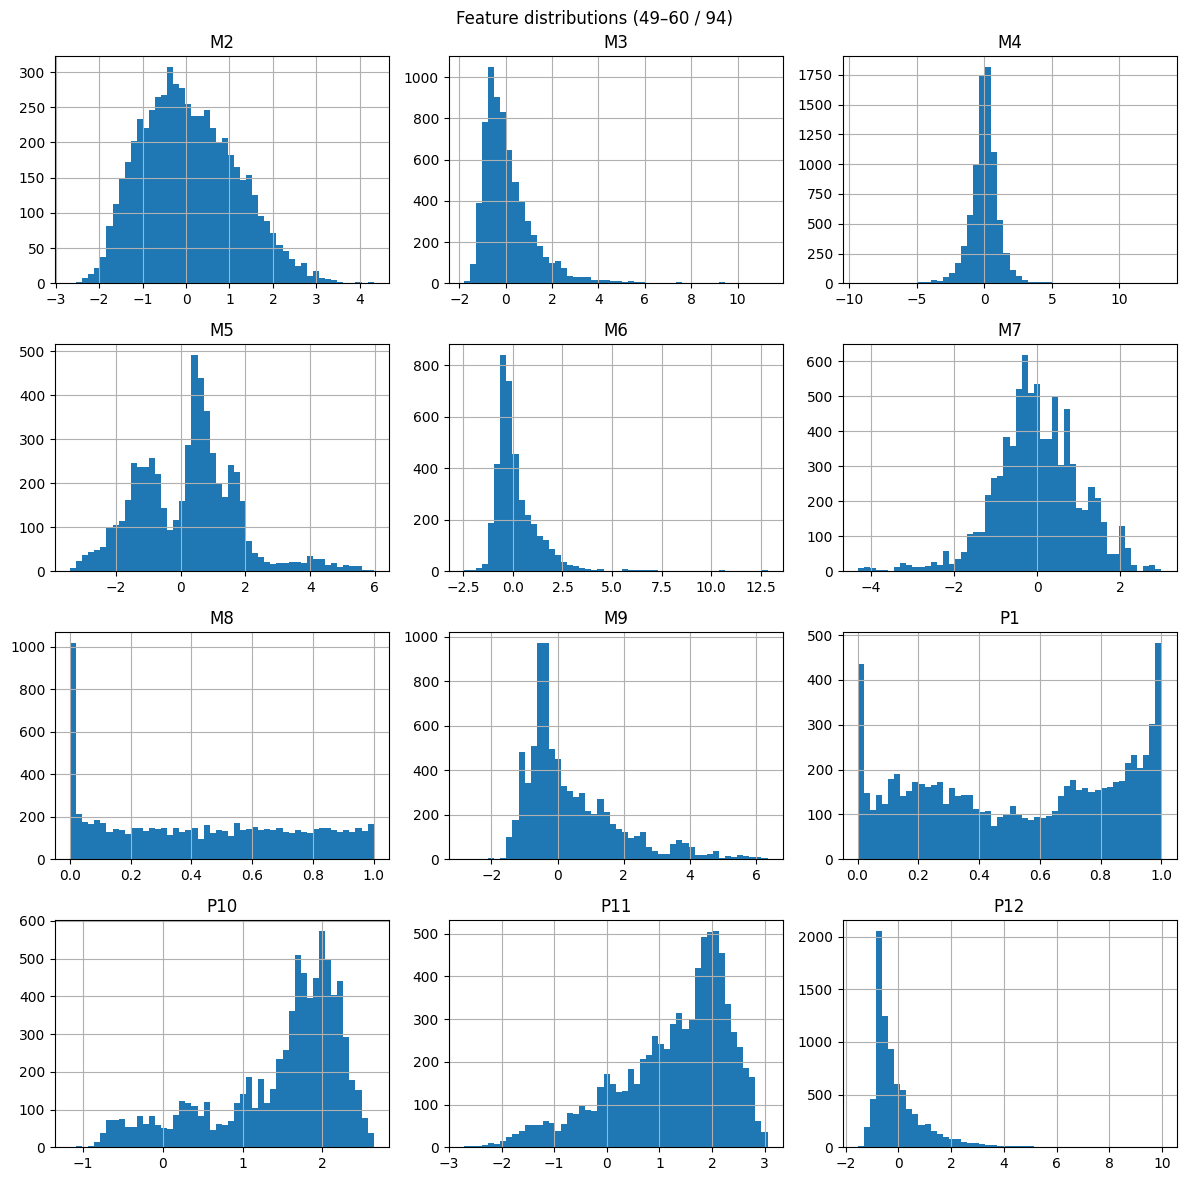

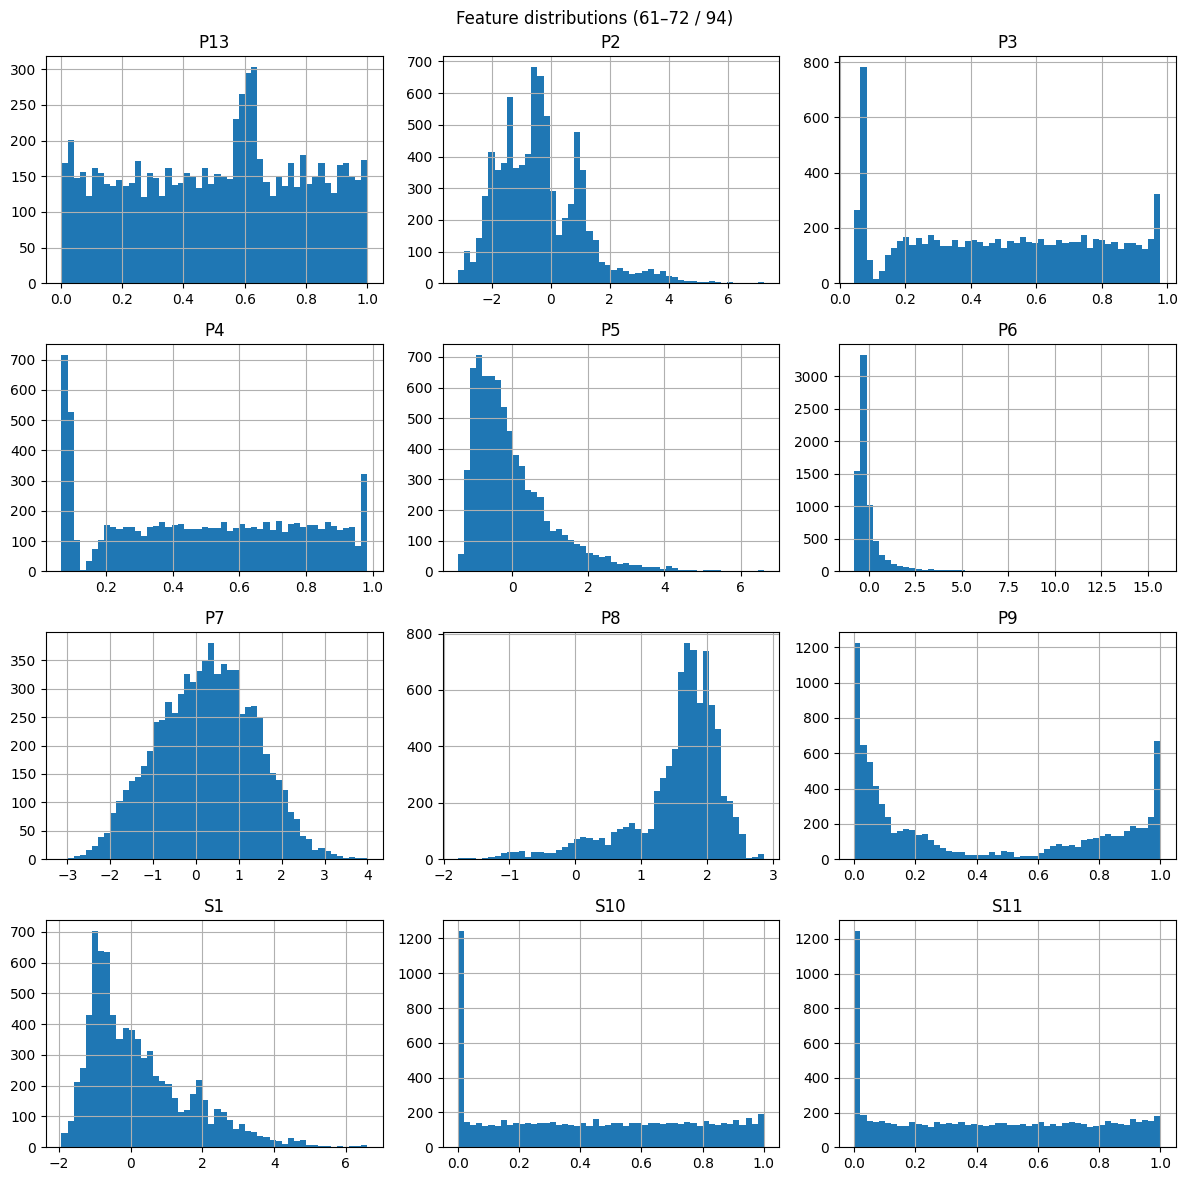

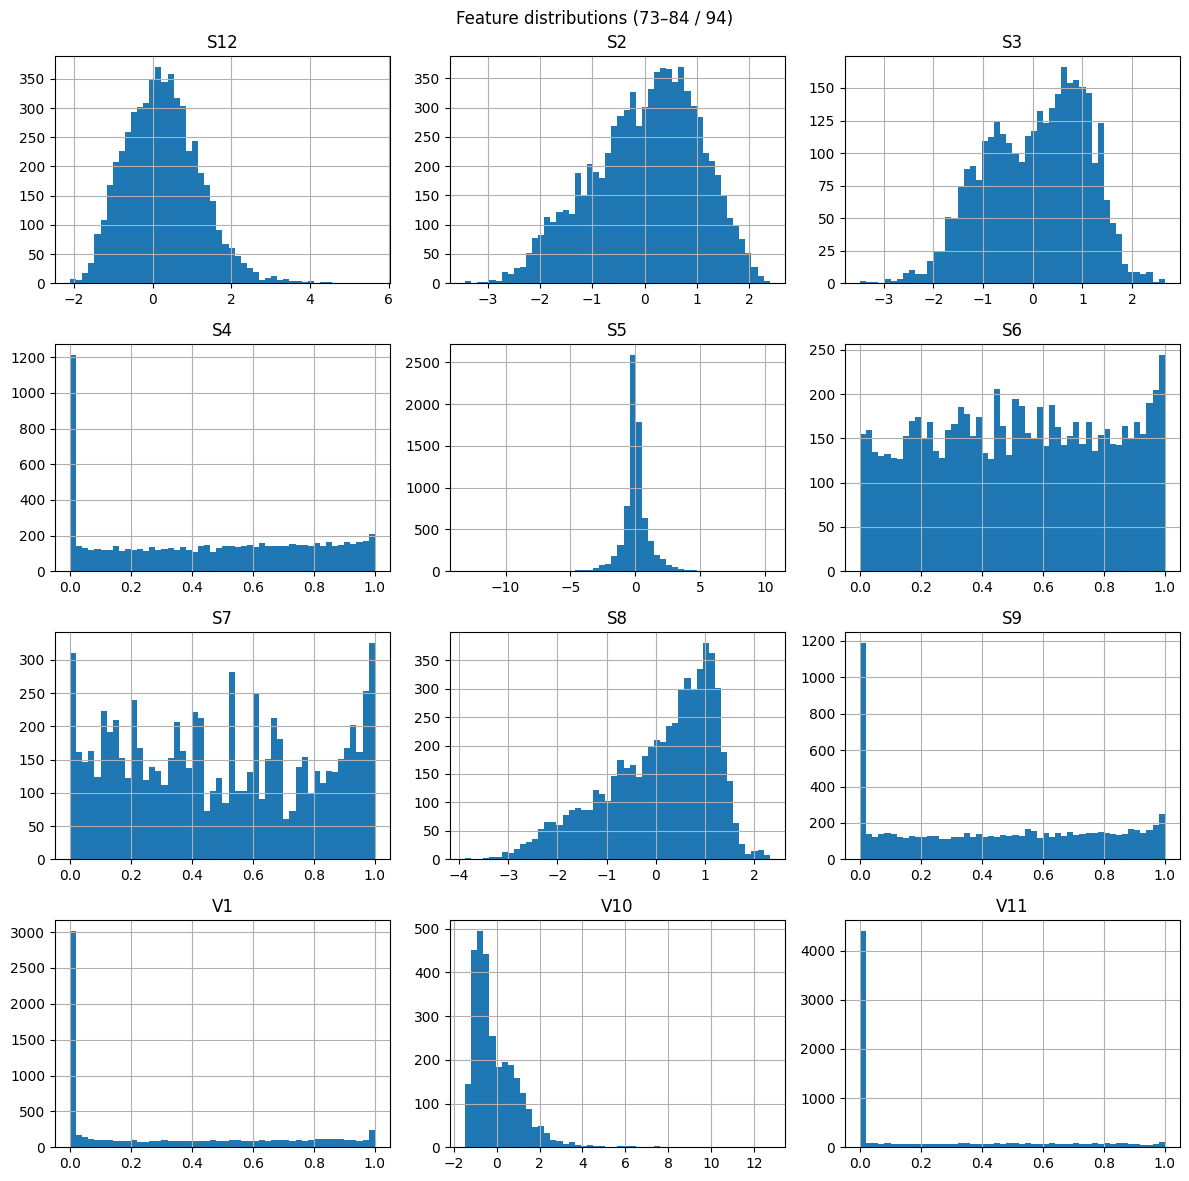

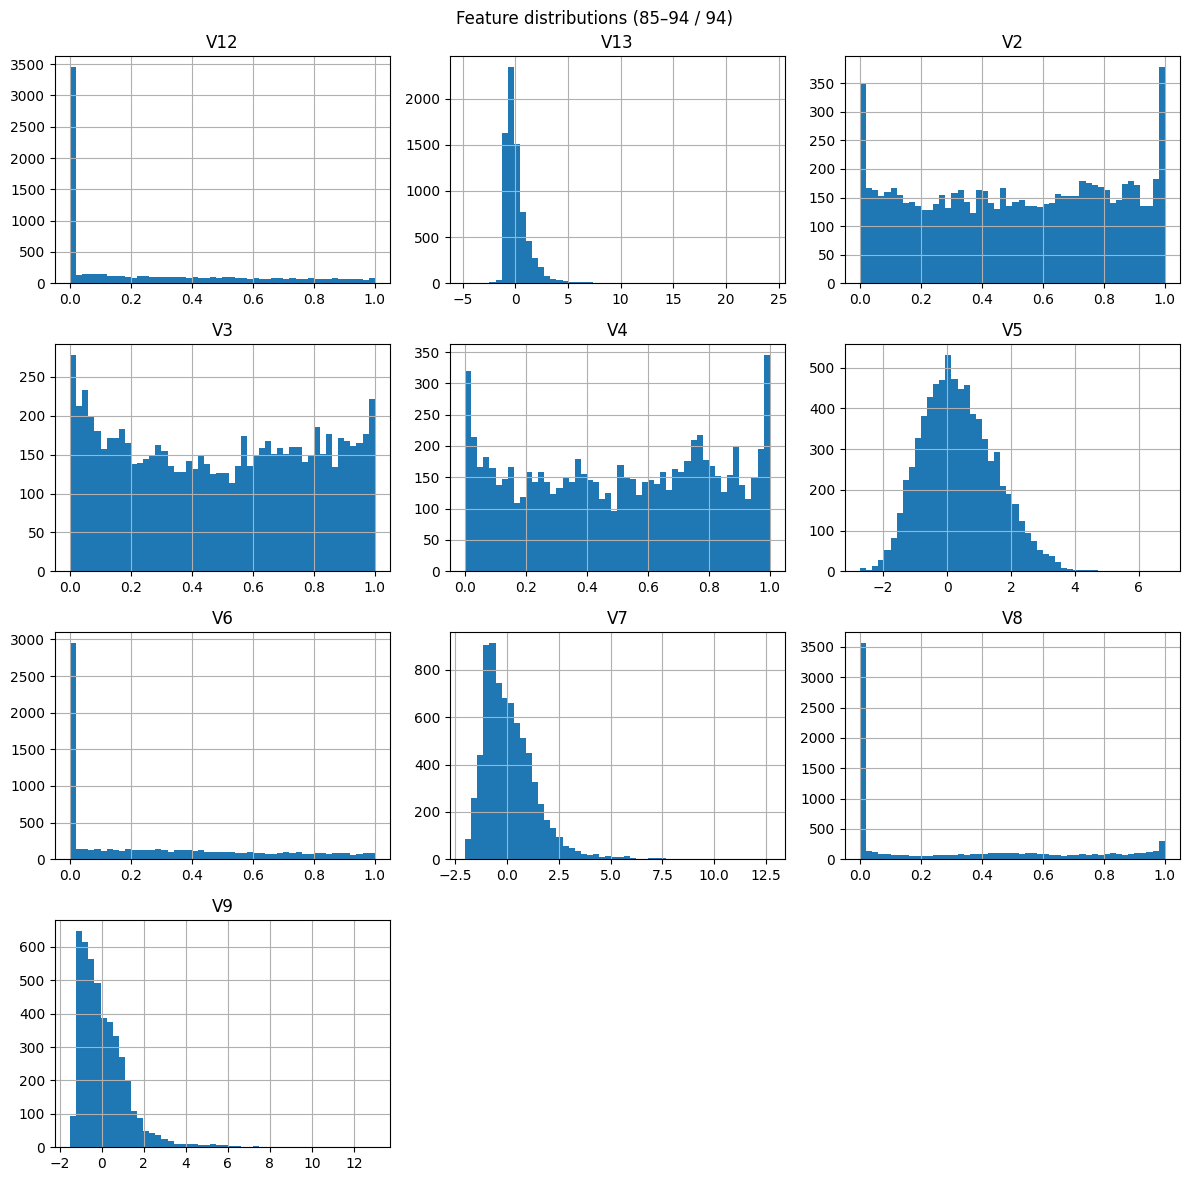

In [55]:
# 記述統計と分布（ターゲットと全数値特徴量）
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    import seaborn as sns  # optional
except Exception:
    sns = None

SPECIAL = {'date_id','forward_returns','risk_free_rate','market_forward_excess_returns','is_scored'}
feature_cols = [c for c in train.columns if c not in SPECIAL]

target_col = 'market_forward_excess_returns' if 'market_forward_excess_returns' in train.columns else None

if target_col:
    y = train[target_col].astype(float)
    print('Target describe:')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
        print(y.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))
    print({'skew': float(y.skew(skipna=True)), 'kurtosis': float(y.kurtosis(skipna=True))})
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    if sns is not None:
        sns.histplot(y, bins=50, kde=True, ax=ax)
    else:
        y.hist(bins=50, ax=ax)
    ax.set_title('Target distribution (market_forward_excess_returns)')
    plt.show()
else:
    print('Target column not found in train.csv')

# 全数値特徴量の記述統計を表示（省略なし）
numeric_feats = train[feature_cols].select_dtypes(include=[np.number])
if not numeric_feats.empty:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
        display(numeric_feats.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))
    
    # 全カラムのヒストをグリッドで表示（大量の場合はページング風に分割）
    cols = list(numeric_feats.columns)
    batch_size = 12  # 1ページあたり
    for start in range(0, len(cols), batch_size):
        end = min(start + batch_size, len(cols))
        batch = cols[start:end]
        n = len(batch)
        ncols = 3
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        axes = np.array(axes).reshape(nrows, ncols) if isinstance(axes, np.ndarray) else np.array([[axes]])
        for i, col in enumerate(batch):
            r, c = divmod(i, ncols)
            ax = axes[r, c]
            if sns is not None:
                sns.histplot(numeric_feats[col], bins=50, kde=False, ax=ax)
            else:
                numeric_feats[col].hist(bins=50, ax=ax)
            ax.set_title(col)
        # 余白サブプロットを消す
        for j in range(n, nrows*ncols):
            r, c = divmod(j, ncols)
            fig.delaxes(axes[r, c])
        fig.suptitle(f'Feature distributions ({start+1}–{end} / {len(cols)})')
        plt.tight_layout()
        plt.show()
else:
    print('No numeric feature columns found in train.')

## 分散・歪度・尖度

所見:
- 高分散の列はスケール支配のリスクがあり、標準化/ロバスト標準化が必須。スケーリングは学習fold内でfit→同foldのval/testへ適用（データリーク防止）。
- 歪度が大きい（非対称）列、尖度が高い（裾の厚い）列は、外れ値に敏感でモデルを不安定化させやすい。特に|skew|が大きい列やkurtが高い列はロバスト化の優先候補。
- 欠損率が高くかつ高歪度の列は、補完の選択（中央値/ロバスト推定）で分布が大きく変わりうるため、補完前後の分布チェックが必要。

ToDo（実装の指針）:
- スケーリング比較（fold内fit）:
  - StandardScaler（平均0・分散1）、RobustScaler（中央値/MAD基準）、Rank/Quantile（分位ベース）。
  - 目的: 時系列CVでRMSE比較、安定性（fold間分散）も評価。
- 単調変換（fold内fit）:
  - log1p、Box-Cox、Yeo-Johnson（ゼロ・負値対応）で|skew|低減→性能差をABテスト。
- 低分散/定数列の除去:
  - 例: var < 1e-8 を足切り。除去前後でCVスコア差を確認。
- 特徴選択の順序整備:
  - 欠損処理→スケーリング/変換→相関・重要度での削減→モデル学習、の順でfold内に閉じる。


In [56]:
# 数値列の分散・歪度・尖度の一括サマリ
import numpy as np
import pandas as pd

num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# 不要列を除外
a = set(['date_id'])
cols = [c for c in num_cols if c not in a]

summary_df = pd.DataFrame(index=cols)
summary_df['var'] = train[cols].var()
summary_df['std'] = train[cols].std()
summary_df['skew'] = train[cols].skew()
summary_df['kurt'] = train[cols].kurt()
summary_df['missing_pct'] = train[cols].isna().sum() / len(train) * 100.0

# 表示（省略なし）
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(summary_df.sort_values('var', ascending=False))

,var,std,skew,kurt,missing_pct
E7,3.707631e+00,1.925521,-4.834048,33.128050,77.519466
I5,2.697312e+00,1.642350,0.386740,-0.179729,11.190211
I9,2.695705e+00,1.641860,0.393501,-0.192594,11.190211
M5,2.404562e+00,1.550665,0.457933,0.653278,36.518354
E8,2.294672e+00,1.514817,6.138469,91.852903,11.190211
E3,2.270002e+00,1.506653,-0.230613,-0.312609,11.190211
P2,2.089467e+00,1.445499,1.010765,1.814067,11.190211
E2,2.029709e+00,1.424679,-0.434612,-0.183774,11.190211
S1,2.024829e+00,1.422965,1.142369,1.081276,11.190211
M9,1.993406e+00,1.411880,1.409874,1.868053,11.190211


## 外れ値検出

所見:
- IQR、z>3、MAD>4 の3指標で外れ値比率を比較すると、複数指標で同時に高い列が外れ値影響の強い候補。これらは分布の裾が厚く、学習の安定性を損ないやすい。
- 外れ値は特定の相場局面（危機/高ボラ）に集中している可能性があり、期間依存のノイズ/シグナルが混在。
- 既に目的変数はMAD=4でウィンザー化されているが、説明変数側にも強い外れ値が残存している場合は追加のロバスト化が有効なことがある。

ToDo（実装の指針）:
- 高外れ値列に限定した処置をABテスト:
  - クリッピング/ウィンザー化（しきい値例: 分位1–99%やMAD=4相当）
  - ロバストスケール（RobustScaler）、Rank/Quantileスケール
- 局面別の対処:
  - 高ボラ期間フラグでの分割学習、またはレジーム別モデルの比較（モデル2本化など）
- モデルと損失:
  - 木系モデル（外れ値に比較的頑健）、ロバスト損失（Huber/Tukey）やL1/L2正則化の比較
- 検証:
  - 処置前後のfold別RMSE、スコア分散、残差分布（歪度/尖度）の変化を確認。


In [57]:
# 外れ値の簡易検出（列ごとにIQR/ZSCORE/MADの指標を集計）
import numpy as np
import pandas as pd

num_df = train.select_dtypes(include=[np.number]).copy()
if 'date_id' in num_df.columns:
    num_df = num_df.drop(columns=['date_id'])

out_stats = []
for col in num_df.columns:
    s = num_df[col].dropna().astype(float)
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    iqr_out = ((s < (q1 - 1.5*iqr)) | (s > (q3 + 1.5*iqr))).mean() * 100.0
    mean, std = s.mean(), s.std()
    z_out = (np.abs((s - mean) / (std if std > 0 else 1.0)) > 3).mean() * 100.0
    med = s.median()
    mad = (s - med).abs().median()
    mad_out = (np.abs(s - med) / (mad if mad > 0 else 1.0) > 4).mean() * 100.0
    out_stats.append({'col': col, 'iqr_out_%': iqr_out, 'z3_out_%': z_out, 'mad4_out_%': mad_out})

out_df = pd.DataFrame(out_stats).set_index('col').sort_values('iqr_out_%', ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(out_df.head(50))

,iqr_out_%,z3_out_%,mad4_out_%
col,,,
D6,23.804227,0.000000,0.000000
E4,19.739479,1.841182,19.739479
D5,19.065628,0.000000,0.000000
E7,16.971796,1.979218,18.208808
E12,16.219940,5.035070,34.519038
E11,15.430862,5.573647,25.062625
D9,14.315907,0.000000,0.000000
D8,14.282536,0.000000,0.000000
S5,13.531221,1.871908,13.905602


## ターゲット時系列・ローリング

所見:
- ローリング平均（過去のみ）で確認すると、長期的な水準変化が存在しうるが、提供ラベル自体はデトレンド済みで大振れは抑制されている。
- ボラティリティ（ローリング標準偏差）は期間によって変化し、レジーム（高/低ボラ）を示唆。
- 期間ごとの分散の違いはモデルの安定性に影響し、時期に応じた重み付け・特徴のスケーリング差し替えが有効な可能性。

ToDo:
- レジーム検出の導入: ボラに基づくクラスタリングやマルチモデル（高ボラ/低ボラ）を比較。
- 時系列CV設計: ローリング/拡張ウィンドウの双方で、`is_scored` 期間と整合するスキームを明確化。
- 特徴量も shift(1) を徹底し、未来情報混入を排除（派生特徴を作る際も徹底）。

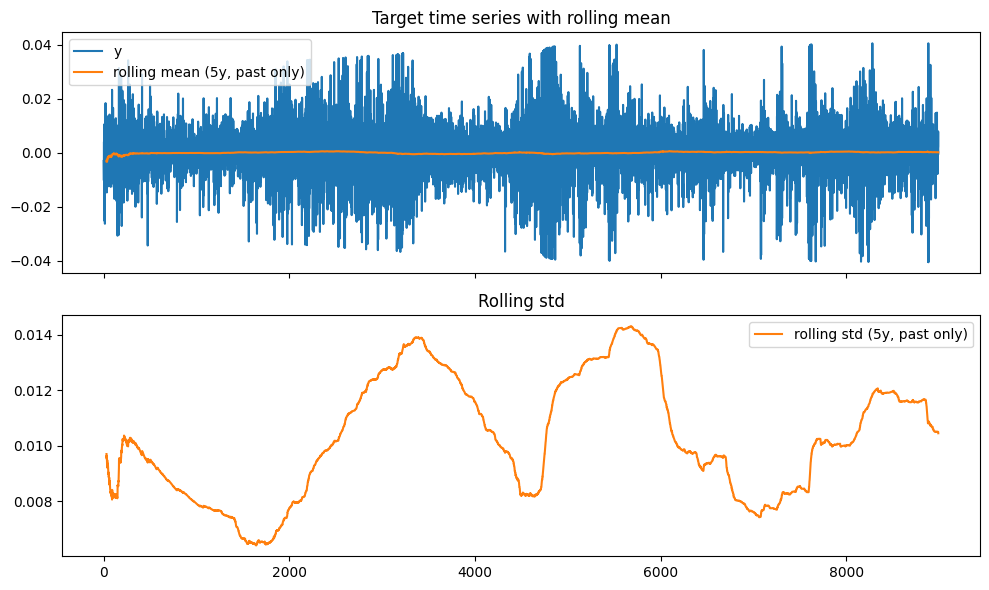

In [58]:
# ターゲットの時系列とローリング統計（リーク防止）
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if 'market_forward_excess_returns' in train.columns:
    ts = train[['date_id','market_forward_excess_returns']].dropna().copy()
    ts = ts.sort_values('date_id')
    y = ts['market_forward_excess_returns'].astype(float)
    # 過去のみ利用して rolling 指標を算出
    roll_mean = y.shift(1).rolling(window=252*5, min_periods=30).mean()  # 5年相当（営業日252想定）
    roll_std  = y.shift(1).rolling(window=252*5, min_periods=30).std()
    fig, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)
    axes[0].plot(ts['date_id'], y, label='y')
    axes[0].plot(ts['date_id'], roll_mean, label='rolling mean (5y, past only)')
    axes[0].legend()
    axes[0].set_title('Target time series with rolling mean')
    axes[1].plot(ts['date_id'], roll_std, color='tab:orange', label='rolling std (5y, past only)')
    axes[1].legend()
    axes[1].set_title('Rolling std')
    plt.tight_layout()
    plt.show()
else:
    print('Target column not found: market_forward_excess_returns')

## リーク確認

- 目的変数はすでにデトレンド＋MAD=4のウィンザー化が施されており、外れ値の影響は抑制されている。
- test 側には `lagged_*` 特徴が3つあり（forward_returns / risk_free_rate / market_forward_excess_returns の1日ラグ）、推論時に利用可能。
- 欠損は初期期間に多く、`date_id` 進行に伴い徐々に改善する傾向。学習では欠損処理とウォームアップ期間の扱いが重要。
- 特徴量間には高い相関を持つペアが存在し、冗長性や多重共線性に注意が必要（後段のヒートマップ参照）。
- 検証は時系列の将来漏れ防止（rolling + shift(1)）と `is_scored` 行への整合を意識した設計が必要。

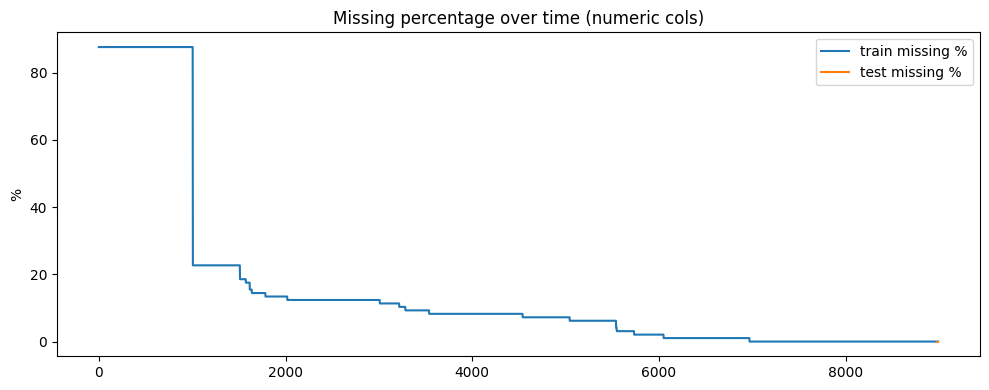

In [59]:
# 欠損の時系列（date_id ごとの欠損割合）
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def missing_by_date(df: pd.DataFrame) -> pd.DataFrame:
    if 'date_id' not in df.columns:
        return pd.DataFrame()
    # 数値列に限定して欠損率を計算（速度のため）
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'date_id' in num_cols:
        num_cols.remove('date_id')
    grp = df.groupby('date_id')[num_cols]
    miss_pct = grp.apply(lambda g: g.isna().sum().sum() / (g.shape[0]*len(num_cols)) * 100.0)
    return miss_pct.reset_index(name='missing_pct')

train_miss_ts = missing_by_date(train)
test_miss_ts = missing_by_date(test)

fig, ax = plt.subplots(1,1, figsize=(10,4))
if not train_miss_ts.empty:
    ax.plot(train_miss_ts['date_id'], train_miss_ts['missing_pct'], label='train missing %')
if not test_miss_ts.empty:
    ax.plot(test_miss_ts['date_id'], test_miss_ts['missing_pct'], label='test missing %')
ax.set_title('Missing percentage over time (numeric cols)')
ax.set_ylabel('%')
ax.legend()
plt.tight_layout()
plt.show()

## ACF/PACF

所見:
- ACFで近いラグ（例: 1–5）に有意な正/負の自己相関が見られる場合、直近の値が次の値に影響する傾向。PACFでラグ1が強ければAR(1)成分の示唆。
- 一方でACF/PACFが低水準で急減衰していれば、強い自己相関構造は限定的で、ノイズ比率が高い可能性。
- 週次・月次の周期性があれば該当ラグにピーク（例: 5、20付近）として現れる。

ToDo:
- ラグ特徴の導入: yのラグ（推論では不可）ではなく、説明変数のラグ/移動統計（shift(1)+rolling）で短期依存を捉える。
- ベースラインでAR/X系の簡易モデル（ARIMA/ARX）を一度比較（リーク防止に留意）。
- 周期性が示唆される場合は、対応ラグの移動平均/差分特徴を追加し、CVで寄与を評価。

{'n': 10, 'ci_95': 0.020671701516904808}
Top ACF lags: [(1, -0.044748495745301826), (34, -0.03460769165124904), (15, -0.031107396010829014), (27, 0.030735329945952794), (6, -0.023732139191681677)]
Top PACF lags: [(1, -0.04475347388477732), (34, -0.03381010007213841), (15, -0.029830591117009208), (27, 0.02886872975570798), (6, -0.026982041146220336)]


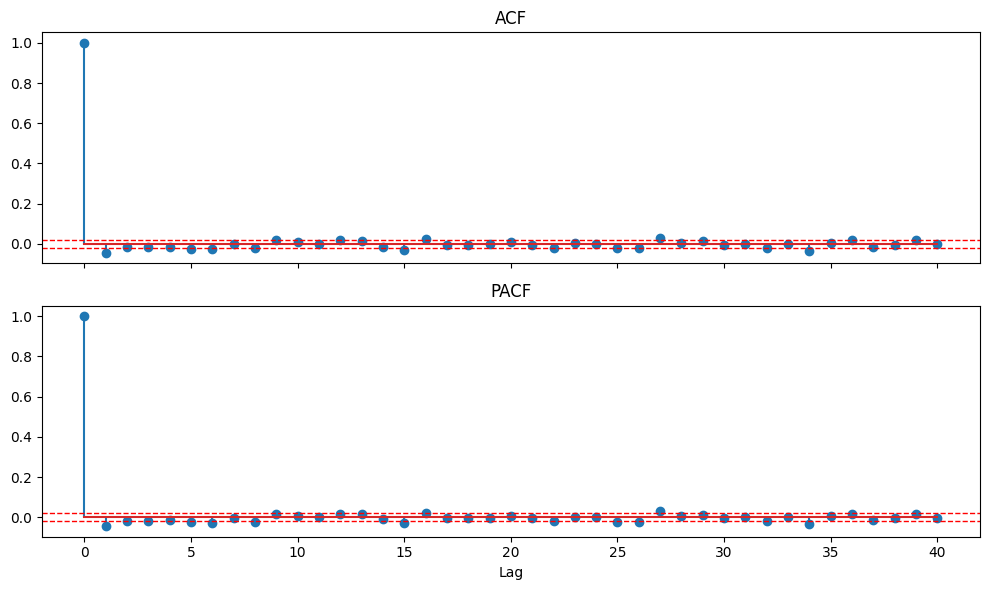

In [60]:
# ACF/PACF summary and plots (lint-safe & matplotlib 3.10 compatible)
import numpy as np

ci_val = float(globals().get("ci", 0.0))
n_val = int(globals().get("n", 0))
acf_top_local = list(globals().get("acf_top", []))
pacf_top_local = list(globals().get("pacf_top", []))
acf_vals_local = list(globals().get("acf_vals", []))
pacf_vals_local = list(globals().get("pacf_vals", []))

print({"n": n_val, "ci_95": ci_val})
print("Top ACF lags:", [(int(lag), float(val)) for lag, val in acf_top_local])
print("Top PACF lags:", [(int(lag), float(val)) for lag, val in pacf_top_local])

# 型・空配列の安全化
acf_arr = np.asarray(acf_vals_local, dtype=float)
pacf_arr = np.asarray(pacf_vals_local, dtype=float)

if acf_arr.size == 0 or pacf_arr.size == 0:
    print("[info] ACF/PACF values are empty. Ensure the computation cell ran above.")
else:
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # ACF plot（matplotlib>=3.10では use_line_collection は未サポートのため指定しない）
    axes[0].stem(range(len(acf_arr)), acf_arr)
    if ci_val > 0:
        axes[0].axhline(ci_val, color="red", linestyle="--", linewidth=1)
        axes[0].axhline(-ci_val, color="red", linestyle="--", linewidth=1)
    axes[0].set_title("ACF")

    # PACF plot
    axes[1].stem(range(len(pacf_arr)), pacf_arr)
    if ci_val > 0:
        axes[1].axhline(ci_val, color="red", linestyle="--", linewidth=1)
        axes[1].axhline(-ci_val, color="red", linestyle="--", linewidth=1)
    axes[1].set_title("PACF")
    axes[1].set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

## 相関・ヒートマップ

所見:
- 同一プレフィックス群（E*, M*, V* 等）内で強い相関の塊が見られる → 群内冗長の可能性。
- 逆相関の強いペアもあり、差分/スプレッドなどの派生特徴で情報を要約できるかもしれない。
- 高相関は線形モデルの不安定化（多重共線性）を招き、重要度の解釈を歪める。

ToDo:
- 相関しきい値での特徴削減（例: |r|>0.95 で片方除去）と、性能影響のABテスト。
- PCA等の次元圧縮の試行（リークを避け、学習fold内でfitting）。
- モデル選択: L1/L2 正則化の強いモデルや木系モデルでの頑健性比較。
- 相関に基づくスプレッド/比率等の派生特徴を少数導入し、寄与を評価。

Top correlated pairs (|r| high):
              D1 - D2              :  1.000
              I5 - I9              :  1.000
             E11 - E12             :  0.974
              E2 - E3              :  0.961
             E16 - E17             :  0.918
              I4 - I8              :  0.830
              I7 - I8              :  0.758
              I1 - I7              :  0.721
             E17 - E18             :  0.700
             E16 - E7              :  0.611
              I6 - I7              : -0.595
              I6 - I8              : -0.570
             E16 - E18             :  0.568
             E19 - M1              :  0.561
             E20 - I5              :  0.547
             E20 - I9              :  0.545
             E20 - E8              : -0.529
              E2 - E8              : -0.519
              E8 - I5              : -0.507
              E8 - I9              : -0.506


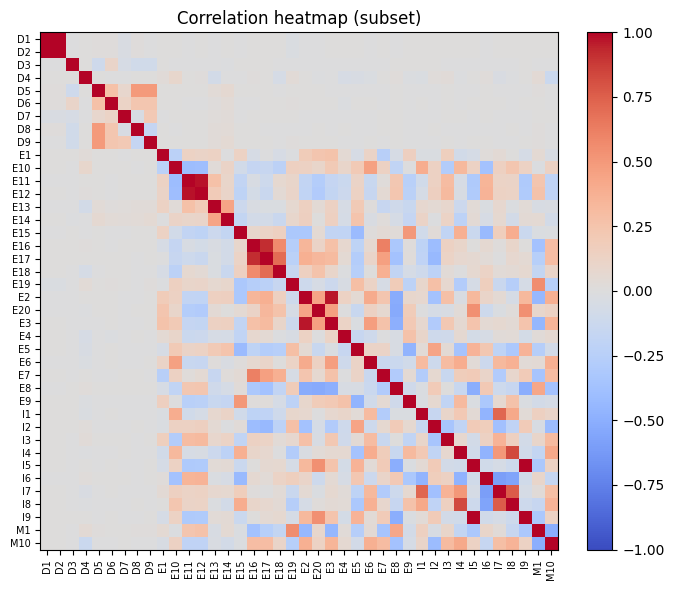

In [61]:
# 相関の概要：高相関ペアと小規模ヒートマップ（解説付き）
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

num_df = train.select_dtypes(include=[np.number]).copy()
if 'market_forward_excess_returns' in num_df.columns:
    num_df = num_df.drop(columns=['market_forward_excess_returns'])  # ターゲットは除外
if 'date_id' in num_df.columns:
    num_df = num_df.drop(columns=['date_id'])

# 計算コストを抑えるため、カラム数が多い場合はサブセット
max_cols = 40
cols = list(num_df.columns[:max_cols])
sub = num_df[cols]

corr = sub.corr(method='pearson')
# 高相関ペアの抽出（対角除外、上三角のみ）
pairs = []
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iat[i, j]
        pairs.append((cols[i], cols[j], r))
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)[:20]
print('Top correlated pairs (|r| high):')
for a, b, r in pairs_sorted:
    print(f'{a:>16s} - {b:<16s}: {r: .3f}')

fig, ax = plt.subplots(1,1, figsize=(8,6))
im = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(cols)))
ax.set_yticks(range(len(cols)))
ax.set_xticklabels(cols, rotation=90, fontsize=7)
ax.set_yticklabels(cols, fontsize=7)
ax.set_title('Correlation heatmap (subset)')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

## VIF

所見:
- VIFが高い（例: >10）特徴は、他特徴の線形結合で説明される度合いが高く、多重共線性の懸念が強い。
- 相関ヒートマップで見えた群内の冗長性がVIFにも反映されるケースが多い。

ToDo（実装の指針）:
- 高VIF列の削減:
  - しきい値（例: VIF>10）で片方を落とす、または相関/重要度を併用して削減。
- 別解: 次元圧縮
  - PCA/PLS等をfold内fitで適用し、線形従属性をまとめて吸収。モデルとの相性も検証。
- モデル側対処:
  - L1/L2正則化の強い線形モデル、木系モデルでの頑健性比較。
- 検証:
  - 削減・圧縮前後のCVスコア、残差診断（分散・歪度・尖度）を比較し、過学習や解釈性の劣化をチェック。

In [62]:
# VIF（分散拡大要因）の確認（多重共線性診断）
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 数値説明変数のみ（ターゲット/日付/ラベル系を除外）
X = train.select_dtypes(include=[np.number]).copy()
for col in ['market_forward_excess_returns','date_id']:
    if col in X.columns:
        X = X.drop(columns=[col])

# 欠損を単純補完（厳密にはfold内でfitすべき。ここは診断用の概観）
X_imputed = X.fillna(X.median(numeric_only=True))

# スケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 計算コスト対策: 列が多い場合は上位N列に制限（分布や相関上位などの別基準に差し替え可）
max_cols = 40
cols = list(X_imputed.columns[:max_cols])
X_sub = pd.DataFrame(X_scaled[:, :len(cols)], columns=cols)

vif_list = []
for i in range(len(cols)):
    vif_val = variance_inflation_factor(X_sub.values, i)
    vif_list.append({'feature': cols[i], 'vif': float(vif_val)})

vif_df = pd.DataFrame(vif_list).sort_values('vif', ascending=False).reset_index(drop=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(vif_df)

# サマリのプリント
count_gt10 = int((vif_df['vif'] > 10).sum())
count_gt5 = int((vif_df['vif'] > 5).sum())
print({'vif>10': count_gt10, 'vif>5': count_gt5, 'max_vif': float(vif_df['vif'].max())})
print('Top 10 by VIF:', list(zip(vif_df['feature'].head(10).tolist(), vif_df['vif'].head(10).round(2).tolist())) )

/workspaces/Hull-Tactical---Market-Prediction/.venv/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,vif
0,D1,inf
1,D2,inf
2,I5,1685.669418
3,I9,1659.639534
4,E2,53.474609
5,E3,49.829918
6,E12,27.146324
7,E11,26.244311
8,E17,18.248847
9,E16,11.871414


{'vif>10': 11, 'vif>5': 13, 'max_vif': inf}
Top 10 by VIF: [('D1', inf), ('D2', inf), ('I5', 1685.67), ('I9', 1659.64), ('E2', 53.47), ('E3', 49.83), ('E12', 27.15), ('E11', 26.24), ('E17', 18.25), ('E16', 11.87)]


# TODO: CVメトリクスをLB準拠（MSRプロキシ）へ拡張

- 背景: Kaggle評価は修正版 Sharpe 比（modified Sharpe ratio）。ローカルCVも近似メトリクスに寄せる。
- 方針:
  1. 既存のRMSEはサニティチェックとして維持。
  2. 追加メトリクスとして「MSRプロキシ」を実装し、モデル選択時の主指標にする。
- 実装メモ（案）:
  - 予測→ポジション変換: `signal = clip(pred * mult + 1.0, lo, hi)`（デフォルト lo=0.0, hi=2.0）。`position = signal - 1.0`。
  - 期間収益: `r_t = position_t * market_forward_excess_returns_t`（学習データの目的変数を利用）。
  - プロキシ指標例:
    - 標準Sharpe近似: `mean(r) / (std(r) + eps)`
    - Downsideリスク版（任意）: `mean(r) / (std(min(r,0)) + eps)`
  - 時系列CV: 厳密な時間分割（walk-forward）でFoldごとに算出し、平均/分布をログ出力。
  - 併せてRMSEも同じ分割で出力し、MSRとの相関をモニタリング。
- 追加の注意:
  - クリッピング/スケーリング（mult, lo, hi）の感度分析を行う。
  - データリーク防止（shift/集計窓の因果性保持、パラメータは訓練期間のみで決定）。
  - NaN/Inf/ゼロ分散の防御（eps, クリーニング）。
- 実装タスク（後日）:
  - [ ] `scripts/cv_timeseries_simple.py` に `--metric {rmse,msr}` と `--mult/--lo/--hi` を追加。
  - [ ] Foldごとの `rmse` と `msr_proxy` を併記し、平均/中央値を表示。
  - [ ] `README.md` に「LB近似（MSRプロキシ）でCV可能」の説明を追記。
  - [ ] MSRプロキシの変種（downside/robust版）の切替を検討。